In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants
from SAnD.utils import load_architecture
from SAnD.model import SAnD

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'pretrain_train_acc', 'pretrain_valid_acc', 'pretrain_grad_norm',
                'train_losses', 'valid_losses', 'train_acc', 'valid_acc', 'grad_norm']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta['final_grad_norm'] = model_meta['grad_norm'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [3]:
def read_transformer_results(root_dir, exp_dir, subject=None):
    args = exp_dir.split('_')[3:]
    df = summarize(os.path.join(root_dir, exp_dir, f's_{subject}' if subject is not None else ''), 'trial_results.csv', 'chan_avg_transformer')

    df = df.assign(n_layers=int(args[0].split('-')[0]))
    df = df.assign(d_model=int(args[1].split('-')[0]))
    df = df.assign(n_heads=int(args[2].split('-')[0]))
    df = df.assign(factor=int(args[3].split('-')[0]))
    df = df.assign(weight_decay=float(args[4].split('-')[0]))
    df = df.assign(dropout=float(args[5].split('-')[0]))
    
    return df

In [4]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'chan_avg_transformer', 'rs',
                        'bandpass_only', 'max_abs_scale',
                        '4_montages', 'no_early_stop', 'cropped', 
                        'pretrain_montage_pool', 'all', 'regularization_grid_search')

subject = '154'

for d in os.listdir(root_dir):
    try:
        df = read_transformer_results(root_dir, d, subject if subject is not None else None)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError as e:
        print(e)
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
valid_cols = ['valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [5]:
all_model_df.columns

Index(['cv_iter', 'Status', 'final_test_accuracy', 'final_test_auc',
       'final_test_f1', 'final_test_loss', 'final_test_precision',
       'final_test_recall', 'final_train_accuracy', 'final_train_auc',
       'final_train_f1', 'final_train_precision', 'final_train_recall',
       'final_valid_accuracy', 'final_valid_auc', 'final_valid_f1',
       'final_valid_precision', 'final_valid_recall', 'grad_norm', 'montage',
       'pretrain_final_test_accuracy', 'pretrain_final_test_auc',
       'pretrain_final_test_f1', 'pretrain_final_test_loss',
       'pretrain_final_test_precision', 'pretrain_final_test_recall',
       'pretrain_final_train_accuracy', 'pretrain_final_train_auc',
       'pretrain_final_train_f1', 'pretrain_final_train_precision',
       'pretrain_final_train_recall', 'pretrain_final_valid_accuracy',
       'pretrain_final_valid_auc', 'pretrain_final_valid_f1',
       'pretrain_final_valid_precision', 'pretrain_final_valid_recall',
       'pretrain_grad_norm', 'pretrai

In [6]:
montage_order = constants.PAIRED_MONTAGES

In [43]:
# weight_decay = 0.0001
# dropout = 0.15

weight_decay = 0.005
dropout = 0.25

n_layers = 1
n_heads = 4
factor = 3
d_model = 32

### Early stopping (validation loss) test accuracy

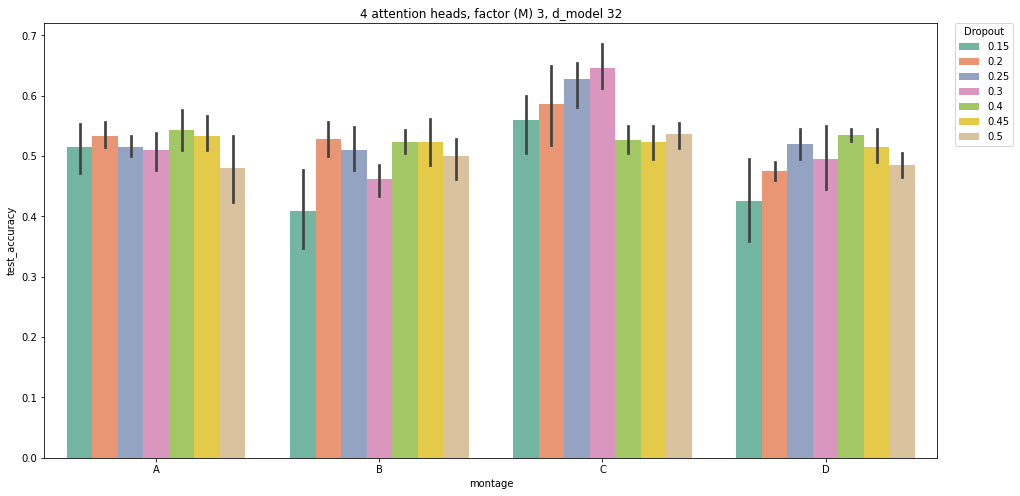

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['n_layers'] == n_layers) &
                              (all_model_df['n_heads'] == n_heads) & 
                              (all_model_df['factor'] == factor) & 
                              (all_model_df['d_model'] == d_model) &
                              (all_model_df['weight_decay'] == weight_decay)],
            x='montage', y='test_accuracy', hue='dropout', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'{n_heads} attention heads, factor (M) {factor}, d_model {d_model}');

### Final test accuracy

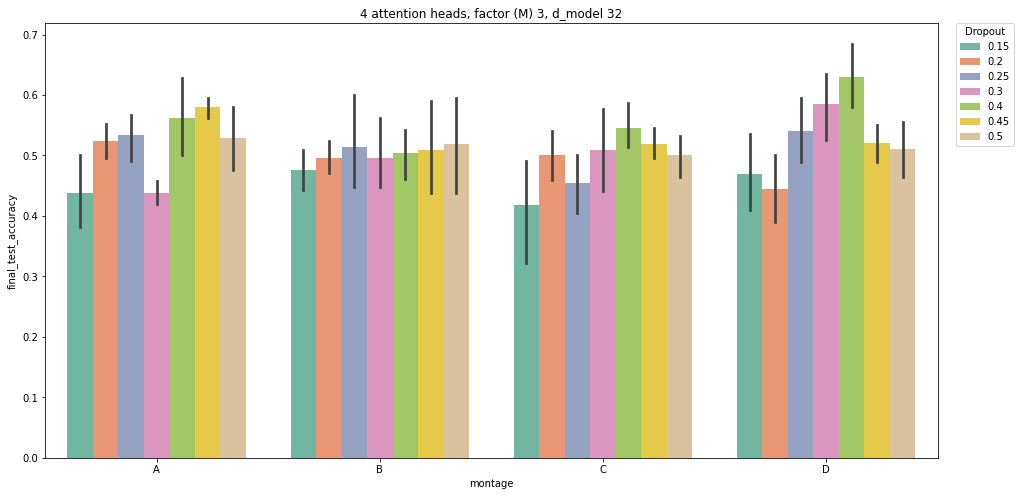

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['n_layers'] == n_layers) &
                              (all_model_df['n_heads'] == n_heads) & 
                              (all_model_df['factor'] == factor) & 
                              (all_model_df['d_model'] == d_model) &
                              (all_model_df['weight_decay'] == weight_decay)],
            x='montage', y='final_test_accuracy', hue='dropout', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'{n_heads} attention heads, factor (M) {factor}, d_model {d_model}');

### Early stopping (validation loss) train accuracy

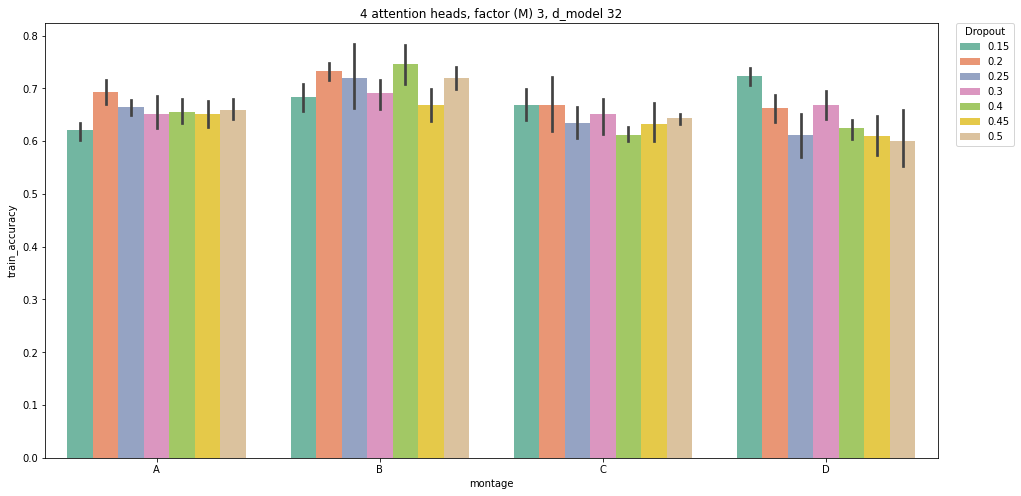

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['n_layers'] == n_layers) &
                              (all_model_df['n_heads'] == n_heads) & 
                              (all_model_df['factor'] == factor) & 
                              (all_model_df['d_model'] == d_model) &
                              (all_model_df['weight_decay'] == weight_decay)],
            x='montage', y='train_accuracy', hue='dropout', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'{n_heads} attention heads, factor (M) {factor}, d_model {d_model}');

### Final train accuracy

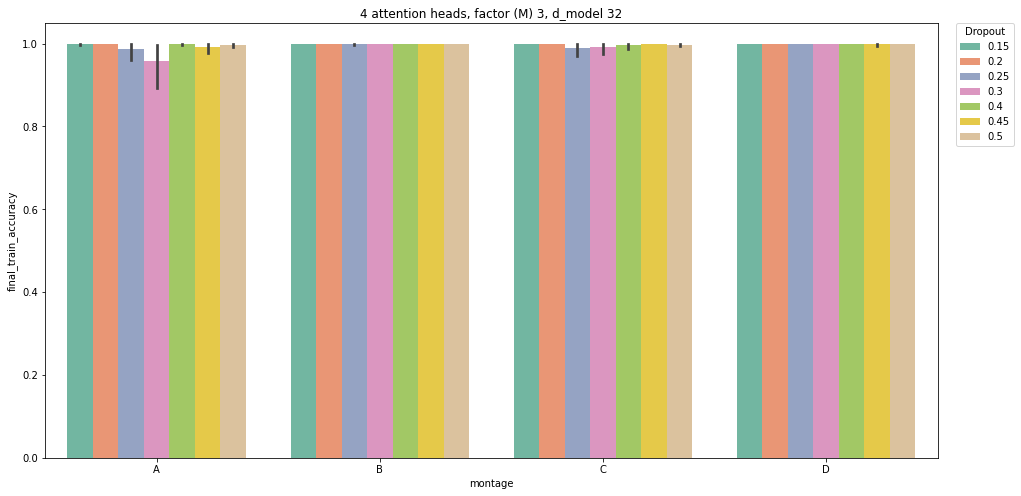

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['n_layers'] == n_layers) &
                              (all_model_df['n_heads'] == n_heads) & 
                              (all_model_df['factor'] == factor) & 
                              (all_model_df['d_model'] == d_model) &
                              (all_model_df['weight_decay'] == weight_decay)],
            x='montage', y='final_train_accuracy', hue='dropout', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'{n_heads} attention heads, factor (M) {factor}, d_model {d_model}');

### Test performance metrics (barplot)

In [48]:
melt_test = pd.melt(all_model_df,
                    id_vars = ['n_layers', 'n_heads', 'factor', 'd_model', 'weight_decay', 'dropout', 'montage'],
                    value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                    var_name = 'metric')
melt_test.loc[:, 'metric'] = melt_test.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())

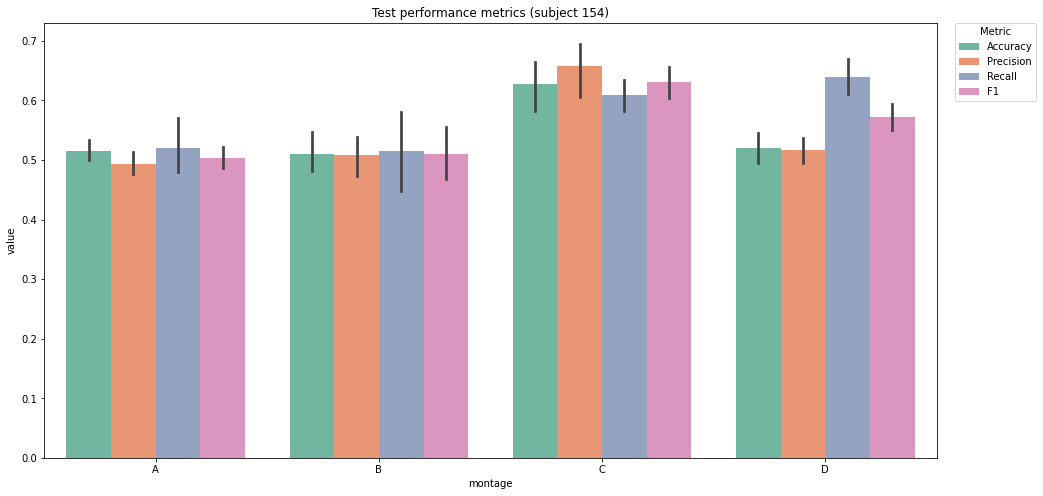

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=melt_test[(melt_test['n_layers'] == n_layers) &
                           (melt_test['n_heads'] == n_heads) & 
                           (melt_test['factor'] == factor) & 
                           (melt_test['d_model'] == d_model) &
                           (melt_test['weight_decay'] == weight_decay) &
                           (melt_test['dropout'] == dropout)],
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Test performance metrics (subject 154)');

In [50]:
output_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout)].groupby('montage').mean()
output_df[test_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,
A,0.514,0.492,0.520,0.504,0.664,0.684,0.575,0.622,300
B,0.510,0.509,0.514,0.510,0.720,0.739,0.706,0.721,300
C,0.627,0.658,0.609,0.631,0.633,0.639,0.650,0.644,300
D,0.520,0.517,0.640,0.571,0.612,0.616,0.659,0.636,300


In [51]:
output_df = output_df[['n_layers', 'n_heads', 'factor', 'd_model',] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'Num Layers', 'Num Heads', 'Factor (M)', 'Dim of Model', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrrr}
\toprule
Montage & Num Layers & Num Heads & Factor (M) & Dim of Model & Accuracy & Precision & Recall &     F1 \\
\midrule
      A &          1 &         4 &          3 &           32 &    0.514 &     0.492 &  0.520 &  0.504 \\
      B &          1 &         4 &          3 &           32 &    0.510 &     0.509 &  0.514 &  0.510 \\
      C &          1 &         4 &          3 &           32 &    0.627 &     0.658 &  0.609 &  0.631 \\
      D &          1 &         4 &          3 &           32 &    0.520 &     0.517 &  0.640 &  0.571 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

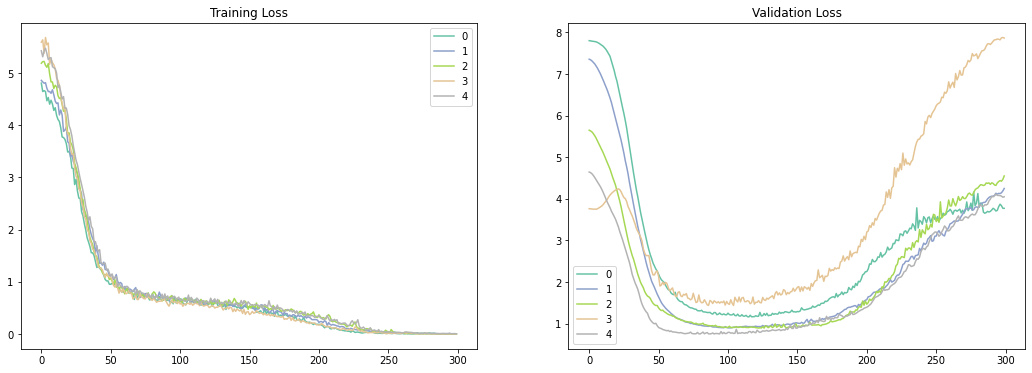

In [26]:
weight_decay = 0.0001
dropout = 0.15

# weight_decay = 0.005
# dropout = 0.25

n_layers = 1
n_heads = 4
factor = 3
d_model = 32

montage = 'C'

subset_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracies

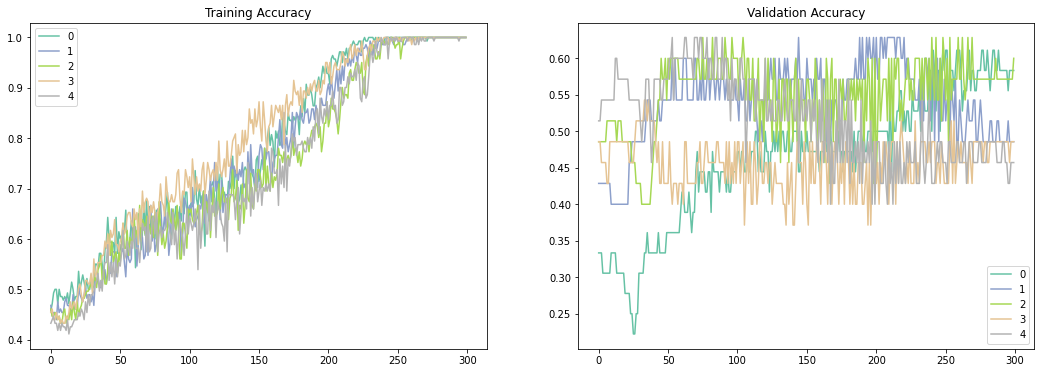

In [27]:
subset_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Gradient Norm

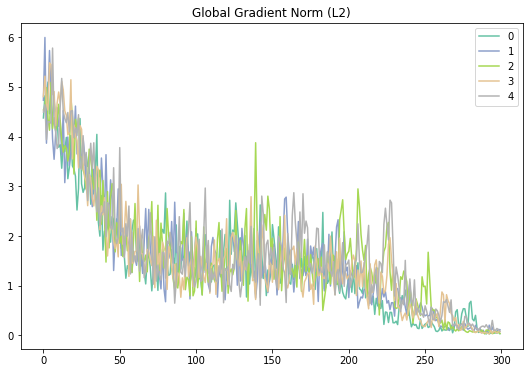

In [28]:
subset_df = all_model_df[(all_model_df['n_layers'] == n_layers) &
                         (all_model_df['n_heads'] == n_heads) & 
                         (all_model_df['factor'] == factor) & 
                         (all_model_df['d_model'] == d_model) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for i, idx in enumerate(subset_df.index):
    ax.plot(subset_df.loc[idx, 'grad_norm'], color=colors[i])
    ax.set_title('Global Gradient Norm (L2)')
    if subject is not None:
        ax.legend(subset_df.cv_iter.unique())
    else:
        ax.legend(subset_df.subject.unique())

## View predictions

In [29]:
montage = 'C'
phase = 'test'
final = False
cv_iter = 3

exp_dir = f'pool_chan_transformer_{n_layers}-layers_{d_model}-dim_{n_heads}-heads_{factor}-M_{weight_decay}-L2_{dropout}-p'

def aggregate_predictions(root_dir, exp_dir, subject, montage, phase):
    
    out_df = pd.DataFrame()
    for i in range(5):
        df = pd.read_parquet(
            os.path.join(root_dir, exp_dir,
                         f's_{subject}' if subject is not None else '',
                         'final_predictions' if final else 'predictions',
                         f'{subject}_{montage}_{phase}_{i}.parquet'))
        out_df = out_df.append(df, ignore_index=True)
        
    return out_df

pred_df = aggregate_predictions(root_dir, exp_dir, subject, montage, phase)
pred_df['pred'] = pred_df['pred'].astype(np.float32)
subset_df = pred_df[pred_df['cv_iter'] == cv_iter]
subset_df

,subject_id,montage,cv_iter,true,pred,prob
132,154,C,3,1.0,0.0,0.031519
133,154,C,3,1.0,1.0,0.703788
134,154,C,3,1.0,1.0,0.941816
135,154,C,3,0.0,1.0,0.919227
136,154,C,3,1.0,1.0,0.691558
137,154,C,3,1.0,1.0,0.901535
138,154,C,3,0.0,0.0,0.490146
139,154,C,3,1.0,0.0,0.054003
140,154,C,3,1.0,0.0,0.442314
141,154,C,3,0.0,1.0,0.551543


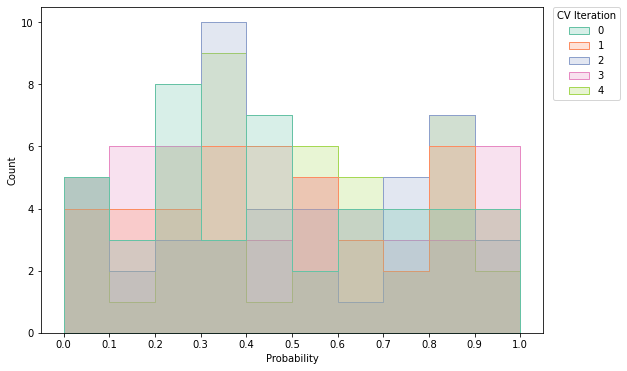

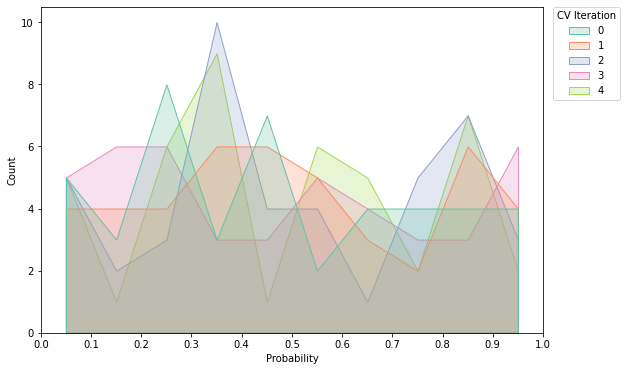

In [30]:
def move_legend(ax, new_title, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if new_title is not None:
        title = new_title
    else:
        title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='step', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='poly', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

In [31]:
from sklearn.metrics import accuracy_score

accuracy_score(subset_df['true'], subset_df['pred'])

0.45454545454545453

In [32]:
np.bincount(subset_df.true.values.astype(int))

array([21, 23])

In [33]:
subset_df.pred.unique()

array([0., 1.], dtype=float32)